## Carbon Footprint Assessment:
Develop a metric for evaluating building carbon footprints, accounting for energy and water consumption, size, and other factors.

In [23]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import json
import joblib

In [29]:
# Load the schema from the JSON file
with open('./data/schema_cleaned.json') as schema_file:
    schema = json.load(schema_file)

# Convert schema to the format required by pandas
# Note: In this case, we're assuming all the dtypes are compatible with pandas dtypes.
# If there are any discrepancies, you may need to manually adjust the dtypes.
pandas_schema = {key: value for key, value in schema.items()}
print(len(pandas_schema))
feature_list = [key for key, value in schema.items()]
print(f"features = {len(feature_list)}")

# Now df has the schema as specified in the schema.json file

62
features = 62


## Data Preparation
Since not all our data is numerical, we'll need to do some one-hot encoding.
Given all the categorical columns, we're going to use pandas library for one-hot encoding.

In [30]:
# Now read the cleaned CSV file using the schema
df_cleaned = pd.read_csv('./data/data_cleaned.csv', dtype=pandas_schema)

# Select the categorical columns that need one-hot encoding
categorical_columns = [key for key, value in schema.items() if value == 'object']

# Perform one-hot encoding on the selected columns, and will be used for K-Means
data_encoded = pd.get_dummies(df_cleaned, columns=categorical_columns)  # Perform one-hot encoding

## Feature Selection & Scaling
Choosing the relevant features for clustering the different types of buildings

In [31]:
# Perform dimensionality reduction using PCA
pca = PCA(n_components=2)  # Adjust the number of components as needed
reduced_features = pca.fit_transform(data_encoded)


In [33]:
column_names = [f'PC{i}' for i in range(1, 3)]
print(column_names)

['PC1', 'PC2']


## K-Means Clustering
We should 

/Users/bgutu/Desktop/Fall23/Hackton/DS-Hackathon-Fall-2023/.venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


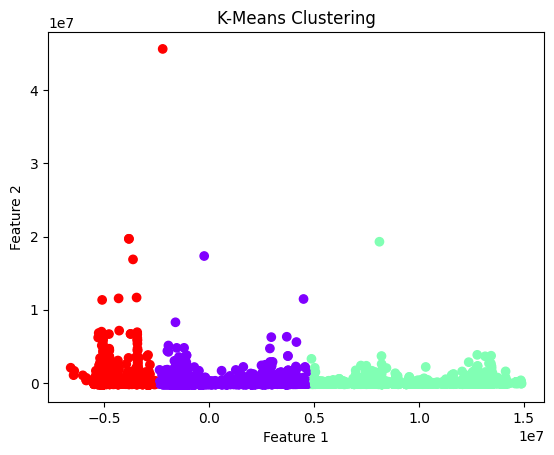

In [39]:
# Choose the number of clusters (K)
K = 3  # Replace with the desired number of clusters

# Create a K-Means model
kmeans_model = KMeans(n_clusters=K, random_state=42)

# Fit the K-Means model to the reduced features
kmeans_model.fit(reduced_features)

# Get cluster assignments for each data point in the dataset
cluster_assignments = kmeans_model.predict(reduced_features)

# Create a scatter plot to visualize the clusters
plt.scatter(reduced_features[:,0], reduced_features[:,1], c=cluster_assignments, cmap='rainbow')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('K-Means Clustering')
plt.show()